In [4]:
import pandas as pd
from utils.utility_functions import *

removing blanks
returning accepted signals


,injection_order,sample_type,sample_type_original,batch,batch_folder
sample_name,,,,,
AOU_NIST_001,2,nist,nist,1,AOU_0001
AOU_HHEAR_P1_001,3,hhear p1,hhear p1,1,AOU_0001
AOU_SP_001,4,sp,sp,1,AOU_0001
AOU_S_0001,5,study,study,1,AOU_0001
AOU_S_0002,6,study,study,1,AOU_0001
...,...,...,...,...,...
AOU_S_0159,105,study,study,2,AOU_0002
AOU_S_0160,106,study,study,2,AOU_0002
AOU_NIST_006,108,nist,nist,2,AOU_0002


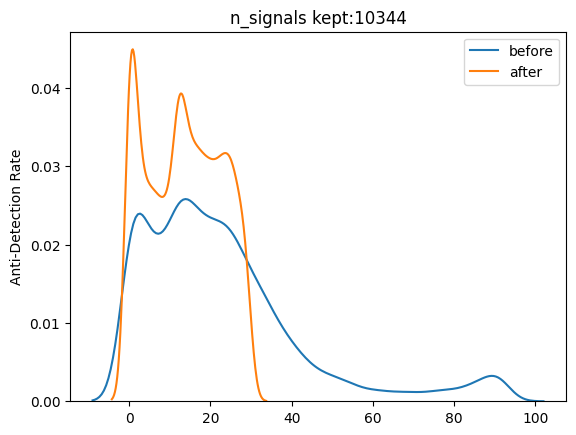

In [6]:
D = pd.read_csv("Data/2-peak_area_after_filling_missing_values.csv").set_index("position").drop(columns=['mz','rt','name']).T
M = pd.read_csv("Data/sample_metadata_all_batches.csv").set_index("sample_name")
D = D[~D.index.str.contains("_B_")]
M = M[~M.index.str.contains("_B_")]
D = D.drop(index='AOU_S_0104')
M = M.drop(index='AOU_S_0104')
D = D[detection(D).index]
D = TIC(D,scale=True)
M

In [16]:
import numpy as np
import pandas as pd 
import patsy
import statsmodels.api as sm 
def batchEffectCorrection(D, M, method='ls'):
    """
    A python implementation for removeBatchEffect, a R function apart of LIMMA (linear models for Microarrays data) package. 
    Removes unwanted batch effects by fitting a linear model to the data and removing the component due to batch effects.  

    Parameters
    ---------
    D: pd.DataFrame
        - Data Matrix of shape (n_signals, n_samples)
    M: pd.DataFrame
        - MetaData Matrix, can have other covariate information, needs to have batch variable and sample_type defined
    method: str {ls ...}
        - Apply OLS to each signal
        - Could add other options such as WLS, GLS
        
    Returns
    -------
    pd.DataFrame
        - Batch-corrected data with same shape as input D (n_signals, n_samples)
    References
    -------
    [1] Smyth, G. K. (2004). Linear models and empirical Bayes methods for assessing
    differential expression in microarray experiments. Statistical Applications 
    in Genetics and Molecular Biology, Vol. 3, No. 1, Article 3.
    http://www.bepress.com/sagmb/vol3/iss1/art3

    """
    if D.shape[0] < D.shape[1]:
        raise ValueError("data matrix is expected to be shape (n_signals, n_samples)")
    
    if method == "ls":
        # Ensure data and batch labels have the same ordering
        M = M.loc[D.columns]

        # Initialize design matrix with deviation encoding of categorical variables
        design = patsy.dmatrix("1 + C(batch, Sum) + C(sample_type,Sum)", data=M)
        n_signals, n_samples = D.shape
        models = []
        n_batches = len(pd.Categorical(M["batch"]).categories)
        
        # Apply signal-wise OLS
        for i in range(n_signals):
            model = sm.OLS(D.iloc[i,:], design)
            results = model.fit(method='qr')
            models.append(results)
            
        # Extract parameters (intercept and batch effect)
        betas = np.array([model.params for model in models])
        
        # Select batch effect parameter(s)
        batch_params = betas[:, 1:n_batches]
        
        # Use all batch indicators from the design matrix
        batch_design = np.asarray(design[:, 1:n_batches])
        
        # Subtract batch effect contribution from data
        batch_effect = batch_design @ batch_params.T
        adjusted_D = D - batch_effect.T  # Keep original shape
        
        #Return Batch-Effect Corrected Data (n_samples, n_signals)
        return adjusted_D.T
    else:
        raise ValueError(f"Method '{method}' not implemented")


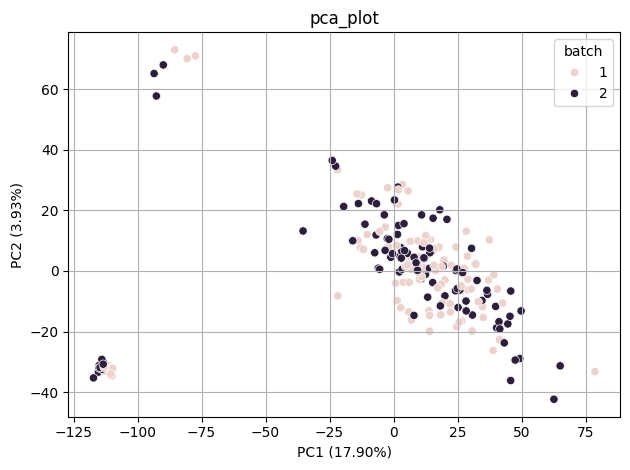

In [17]:
limma = batchEffectCorrection(D.T,M)

pca_plot(limma,M,hue='batch')

In [18]:
design = patsy.dmatrix("1 + C(batch, Sum) + C(sample_type,Sum)", data=M)

In [19]:
design

DesignMatrix with shape (200, 6)
  Columns:
    ['Intercept',
     'C(batch, Sum)[S.1]',
     'C(sample_type, Sum)[S.hhear p1]',
     'C(sample_type, Sum)[S.hhear p2]',
     'C(sample_type, Sum)[S.nist]',
     'C(sample_type, Sum)[S.sp]']
  Terms:
    'Intercept' (column 0)
    'C(batch, Sum)' (column 1)
    'C(sample_type, Sum)' (columns 2:6)
  (to view full data, use np.asarray(this_obj))